# Dip picking
- [Balthazar Neveu](https://www.linkedin.com/in/balthazarneveu/)
- TP-4 [Introduction to geosciences](https://www.master-mva.com/cours/introduction-a-lapprentissage-statistique-pour-les-geosciences/) | ENS Paris Saclay - [Master MVA](https://www.master-mva.com/) 2024
- [Web version](https://balthazarneveu.github.io/geosciences) | [Github](https://github.com/balthazarneveu/geoscience)

# Preliminary: instructions and method


## Sinusoid extraction: automated trend extraction using randomized hough transform
Implement randomized Hough transform:
-  Compute gradient of image and associated vectors
-  Display the vectors
-  Pick randomly vectors and compute their vectorial product; store them in an accumulator
-  Take the most probable vector
-  Compute the associated angles
-  Display the associated sinusoid
- DEPTH in feet, DIAMETER 8.5 inches

### Proposed approach to solve the problem

#### Step A: solve the problem on synthetic data
1. Write 3D simulation and Forward = synthezis & Inverse = fit the plane methods:
- *Synthesis*: Simulate 3D vectors: compute tangent vector to the cylinder when they intersect with a plane
- *Inverse*: Perform method 1: Fit the plane first using the vector product by taking random samples.
- *Inverse*: Perform method 2: Formulation as an optimization problem
- Add a bit of noise, check sensitivity. Check sensitivity to noise and number of samples

2. Simulate imaging:
- *Synthesis*:Simulate 2D projection
- *Inverse*: Go backwards from 2D gradients to 3D gradients.


#### Step B: Apply to real images
- Work to windows first.
- Extract gradients, remove vertical.
- Normalize unit correctly
- *Are the vertical patterns annoying, if yes, we should almost use the method from TP3 (but it seems that the holes images have been resampled already (not straight)?*



In [1]:
from plane_cylinder_projections import *
from visualizations import (plot_ground_truth_3d, validation_of_3d_tangent_estimation, show_borehole_image,
                            show_gradients_magnitudes, plot_tangents_and_gradients_field, plot_3d_scatter, COLORS)
from simulations import DEFAULT_PLANE_ANGLES, create_planes_projection, simulated_splat_image, get_3d_tangent_estimation_using_groundtruth
from image_processing import extract_2d_gradients_from_image
from data_processing import load_data, extract_2d_gradients
from constants import *
import matplotlib.pyplot as plt
import numpy as np
from skimage import filters
from plane_extraction import get_cross_products
%load_ext autoreload
%autoreload 2


# Direct application to borehole images 

(12001, 360)


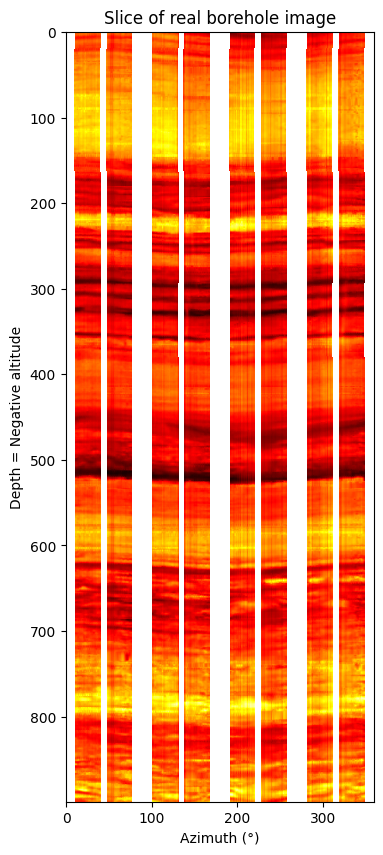

In [2]:
image_input, mask_absent, image_display, tdep = load_data()
roi = image_display[400:1300]
show_borehole_image(roi, title='Slice of real borehole image')

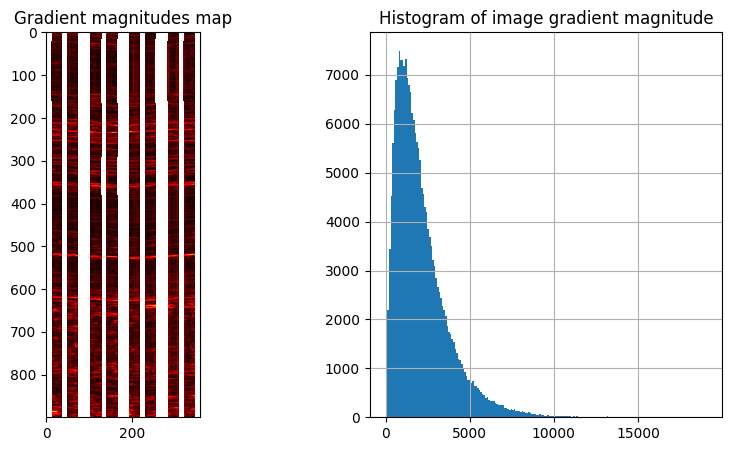

In [3]:
extract_2d_gradients(roi, bins=200)

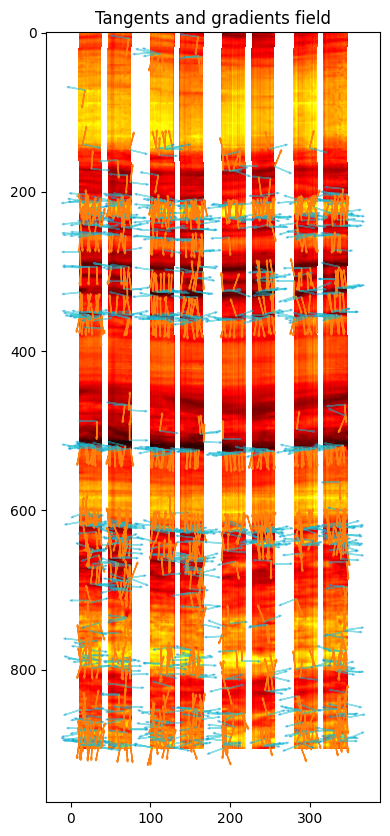

In [4]:
img_grad_h, img_grad_v, img_grad, coords = extract_2d_gradients_from_image(
    roi,
    threshold_magnitude=5000.,
    thresold_abs_v_grad=3000
)
plot_tangents_and_gradients_field(coords, img_grad_h, img_grad_v, roi, decimation=10, title='Tangents and gradients field')

In [6]:
# Compute the correctly scaled tangent vectors (in SI units, angles in radians, altitudes in meters)
tan_vec_2d = get_tangent_vec_from_gradients(img_grad_h, img_grad_v, normalize=False)
img_coords = torch.from_numpy(coords).float()
p3D_est = angle_to_3d_vector(np.deg2rad(img_coords[:, 1]), -img_coords[:, 0]*DEPTH_STEP).unsqueeze(0)


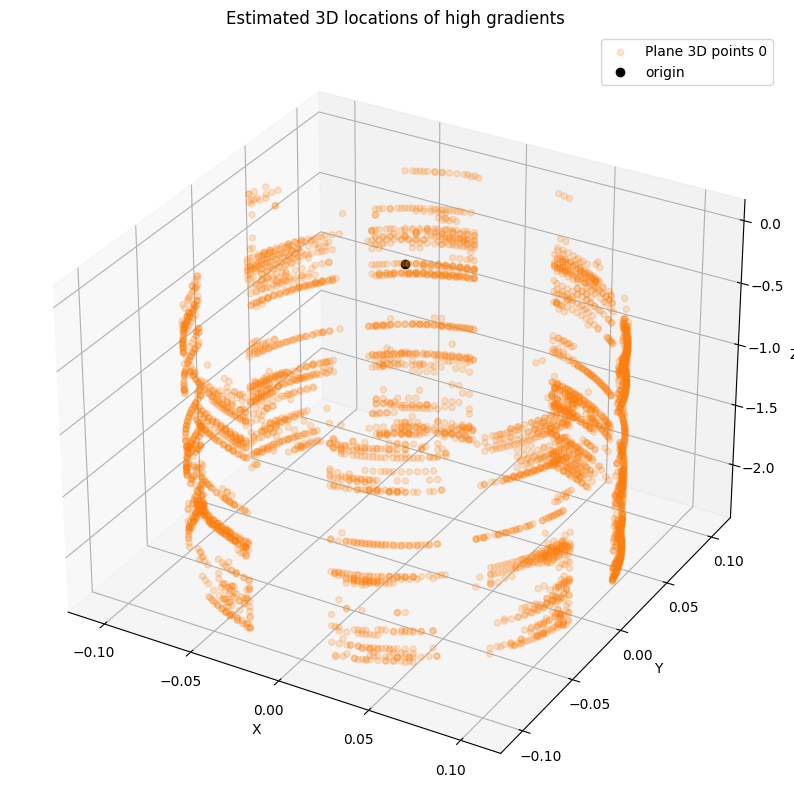

In [7]:
plot_3d_scatter(p3D_est[:, ::2], title="Estimated 3D locations of high gradients", forced_color="tab:orange", alpha=0.2)

In [8]:
# Compute the 3D tangent vectors (and normalize)
img_coords = torch.from_numpy(coords).float()
p3D_est = angle_to_3d_vector(np.deg2rad(img_coords[:, 1]), -img_coords[:, 0]*DEPTH_STEP).unsqueeze(0)

azi_list = torch.deg2rad(img_coords[:, 1]).unsqueeze(0)
alt_list = -img_coords[:, 0]*DEPTH_STEP
tangent = np.array([
    -img_grad_v, # y 
    img_grad_h,
]).T
tangent.shape
tangents_3d = []
for idx in range(azi_list.shape[1]):
    azi = azi_list[0, idx]
    alt = alt_list[idx]
    delta_azi = tan_vec_2d[idx, 0]
    delta_alt = tan_vec_2d[idx, 1]
    tan3d = image_vector_to_3d_plane_tangent(azi, alt, delta_azi, delta_alt)
    tan3d = tan3d / tan3d.norm() # normalize the 3D tangent
    tangents_3d.append(tan3d)
tangents_3d = torch.stack(tangents_3d, dim=0).unsqueeze(0)

cross_product_estimated, cross_product_norm_estim = get_cross_products(tangents_3d, num_points=10000)

In [9]:
cross_product_estimated, cross_product_norm_estim = get_cross_products(tangents_3d, num_points=50000)

In [10]:
dip_az_estim = normal_vector_to_angles(cross_product_estimated)
# dip_az_estim[..., 1] = dip_az_estim[..., 1] % (np.pi/2)
dip_az_estim[..., 1] = dip_az_estim[..., 1] % (np.pi)

In [11]:
dip_az_estim.shape

torch.Size([1, 50000, 2])

In [12]:
cross_product_norm_estim.shape

torch.Size([1, 50000, 1])

In [13]:
histo, bin_edges  = torch.histogramdd(dip_az_estim, bins = [20, 20])
maxi = torch.max(histo)
print(maxi)
amax_mode = torch.where(histo == maxi)
print(amax_mode)
# Calculate the midpoint of the bins for plotting
x_mid = (bin_edges[1][amax_mode[1]+1] + bin_edges[1][amax_mode[1]]) / 2.0
y_mid = (bin_edges[0][amax_mode[0]+1] + bin_edges[0][amax_mode[0]]) / 2.0

best_dip = y_mid[0]
best_azimuth = x_mid[0]
print(f"Estimated dip: {np.rad2deg(best_dip):.3f}° and azimuth: {np.rad2deg(best_azimuth):.3f}°")

tensor(414.)
(tensor([2]), tensor([15]))
Estimated dip: 11.292° and azimuth: 139.492°


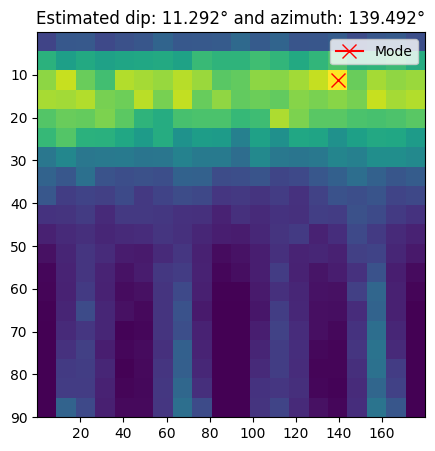

In [14]:
plt.figure(figsize=(5, 5))
plt.imshow(
    histo,
    extent=[
        np.rad2deg(bin_edges[1][0]), np.rad2deg(bin_edges[1][-1]),
        np.rad2deg(bin_edges[0][-1]), np.rad2deg(bin_edges[0][0]),
    ],
    aspect='auto')
plt.plot(
    np.rad2deg(x_mid),
    np.rad2deg(y_mid),
    marker="x", color="red", markersize=10, label="Mode")
plt.title(f"Estimated dip: {np.rad2deg(best_dip):.3f}° and azimuth: {np.rad2deg(best_azimuth):.3f}°")
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


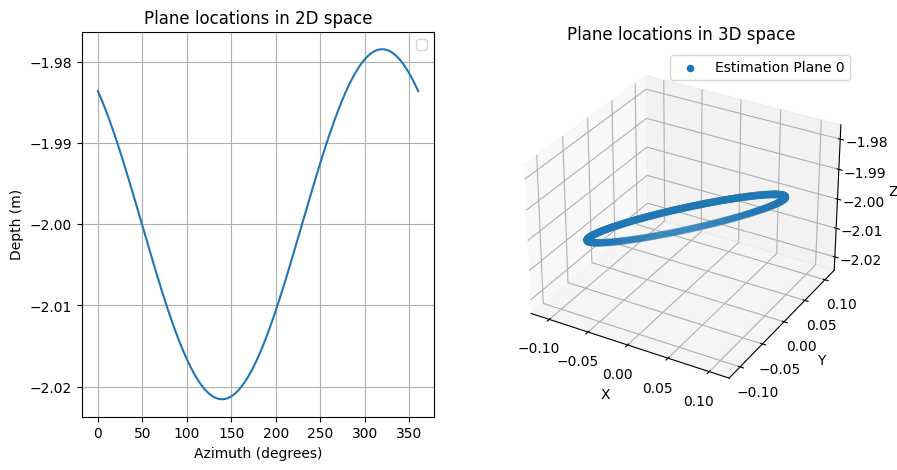

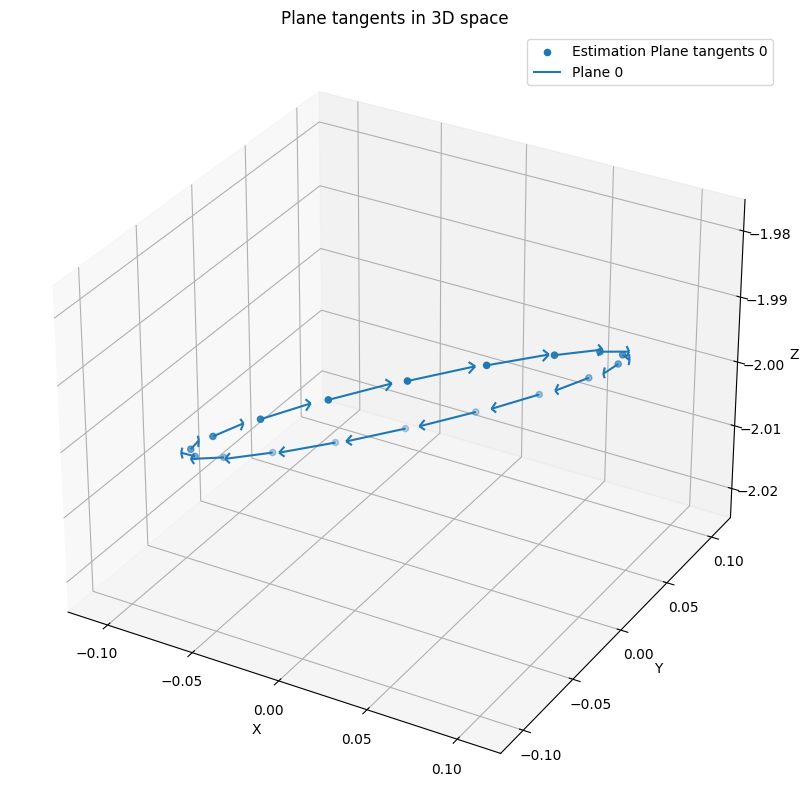

In [16]:
estimated_plane_angle = torch.tensor(
    [
        [best_dip, best_azimuth, -2.],
    ]
)
# Let's visualize the normal vectors (from angles to 3D vectors)
estimated_normals = angles_to_normal_vector(estimated_plane_angle)
# plot_3d_scatter(point_cloud=None, vects=estimated_normals/15., title="Estimated plane normals")
# Let's sample the azimuth coordinates and compute the altitude of the planes
azimuth_coordinates_phi, altitude_z = create_planes_projection(estimated_plane_angle)
p3D_est = angle_to_3d_vector(azimuth_coordinates_phi, altitude_z=altitude_z) # [N, L, 3]

plot_ground_truth_3d(
    azimuth_coordinates_phi,
    altitude_z,
    p3D_est,
    name= "Estimation"
)

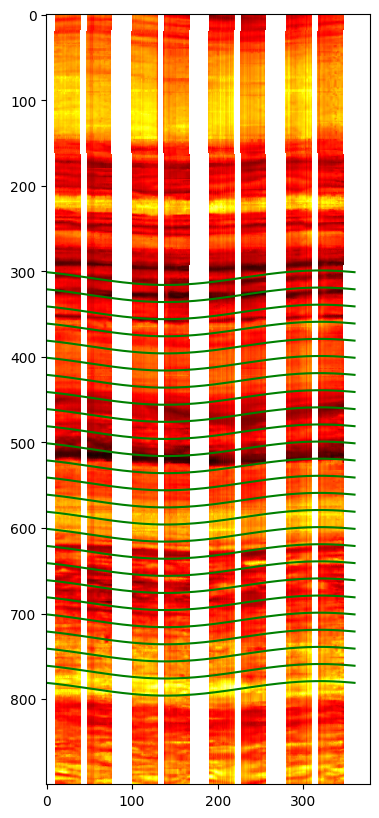

In [43]:
plt.figure(figsize=(10, 10))
plt.imshow(roi, cmap='hot')
for offset in range(0, 500, 20):
    plt.plot(np.rad2deg(azimuth_coordinates_phi).T, -offset-altitude_z.T/DEPTH_STEP, 'g-')
# plt.plot(np.rad2deg(azimuth_coordinates_phi).T, -500-altitude_z.T/DEPTH_STEP, 'g-')
plt.show()

In [ ]:
plot_3d_scatter(
    point_cloud=cross_product_estimated,
    alpha=0.01,
    # fixed="tab:cyan",
    vects=estimated_normals,
    label="Randomized Cross Products",
    label_vector="Normal plane vector (Estimation)",
    title="Randomized Cross product of estimated tangents")

# Synthesis
- PART 1: We'll first define planes
- PART 2: We'll then synthesize planes and work with vector data:
  - by sampling 3D and 2D corresponding points and their normals.
  - we'll validate the concept of plane parameters estimations from tangents.
- PART 3: We'll synthesize borehole images and validate image data processing
  - mimick projected planes, with the same units used in real images
  - extract 2D gradients and tangents
  - deduce 3D tangents
  - use randomized cross products to fit a plane.

# PART 1: Plane definition
A plane is defined by its normal vector $\vec{p}$ and its altitude $z_0$ and also parameterized as 2 angles (dip $\delta$ and azimut $\alpha$)
| Plane and normal $\vec{p}$ | Plane normal vector dip $\delta$ , azim_uth $\alpha$ |
| :--: |  :--: | 
|  ![](report/plane_normal_definition.png) | ![](report/normal_definition.png) |

- If $\delta=0$, horizontal slice ($alpha$ is not informative by the way), we'll get a line in the images
- If $\delta=90°$, vertical plane (corresponds to infinite amplitude oscillation = vertical line).

We'll define a set of planes by a tensor `[N, 3]` where `N` is the batch dimension/number of planes.
Parameters are expressed as 
```
[
    [dip1 (rad), azimuth1 (rad), altitude1 (m)],
    [dip2 (rad), azimuth2 (rad), altitude2 (m)]
]
``` 


In [ ]:
# First, let's define some groundtruth planes (dip, azimut)
# Pick one among several configurations
mixed_slices = ["crazy", "parallel", "bisec_parallel_slight_noise", "parallel_slight_noise", "demo"][3]
if mixed_slices == "crazy":
    plane_angle = torch.tensor(
        [
            [0., 0.,  -0.3],
            [torch.pi/4, torch.pi/4, 0.],
            [0.8*torch.pi/2., torch.pi/4, -1.],
            [0.9*torch.pi/2., torch.pi/3, -0.5],
            [0.1, torch.pi/2, -1.2],
        ]
    )
elif mixed_slices == "parallel":
    plane_angle = torch.tensor(
        [
            [torch.pi/4, torch.pi/4, 0.],
            [torch.pi/4, torch.pi/4, -0.3],
            [torch.pi/4, torch.pi/4, -0.6],
            [torch.pi/4, torch.pi/4, -0.8],
        ]
    )
elif mixed_slices == "bisec_parallel_slight_noise":
    plane_angle = torch.tensor(
        [
            [0.99*torch.pi/4, torch.pi/4, -0.2],
            [torch.pi/4, 0.99*torch.pi/4, -0.3],
            [1.02*torch.pi/4, torch.pi/4, -0.6],
            [torch.pi/4, 1.01*torch.pi/4, -0.8],
        ]
    )
elif mixed_slices == "parallel_slight_noise":
    plane_angle = torch.tensor(
        [
            [0.99*torch.pi/4, 1.4*torch.pi/4, -0.2],
            [torch.pi/4, 0.99*1.4*torch.pi/4, -0.3],
            [1.02*torch.pi/4, 1.4*torch.pi/4, -0.6],
            [torch.pi/4, 1.01*1.4*torch.pi/4, -0.8],
        ]
    )
elif mixed_slices == "demo":
    plane_angle = torch.tensor(
    [
        [0.0, 0., -0.1],
        [0.1, 0., -0.3],
        [0.1, 0.5, -0.4],
        [0.3, 0., -0.5],
        [0.5, 0., -0.7],
        [0.5, -0.5, -0.8],
    ]
    )

In [ ]:
# Let's visualize the normal vectors (from angles to 3D vectors)
normals = angles_to_normal_vector(plane_angle)
plot_3d_scatter(point_cloud=None, vects=normals/15., title="Groundtruth plane normals")

In [ ]:
# Let's sample the azimuth coordinates and compute the altitude of the planes
azimuth_coordinates_phi, altitude_z = create_planes_projection(plane_angle)
p3D_gt = angle_to_3d_vector(azimuth_coordinates_phi, altitude_z=altitude_z) # [N, L, 3]


# PART 2: Fitting planes from vector data

## Sampling the planes
- Let's sample the azimuth coordinates and compute the altitude of the planes.
- We can visualize the groundtruth planes:
  - as a collection of 3D points
  - after projecting into the borehole 2D space (a curve in the image)
- It is also possible to visualize the plane tangents in 3D (use the Jacobian of `image_vector_to_3d_plane_tangent` and multiply by the 2D gradients).

In [ ]:
# We can visualize the groundtruth planes after projecting into the borehole 2D space.
plot_ground_truth_3d(
    azimuth_coordinates_phi,
    altitude_z,
    p3D_gt
)

In [ ]:
groundtruth_grad_list_3d = get_3d_tangent_estimation_using_groundtruth(azimuth_coordinates_phi, altitude_z)

In [ ]:
# The following code is used for visual validation and could be moved to a pytest.
# Computation of the tangent vectors using the jacobian of `image_vector_to_3d_plane_tangent`
# Not normalized!
validation_of_3d_tangent_estimation(
    azimuth_coordinates_phi,
    groundtruth_grad_list_3d,
    p3D_gt=p3D_gt,
    batches_index=[2]
)
# Finite difference gradient or using the jacobian seems to be consistent!

## Concept validation
- Use the groundtruth planes (knowledge on dip dip $\delta$ , azimuth $\alpha$).
- Sample projected points
- Take the tangents, perform randomized cross products, decompose into (dip $\hat{\delta}$ , azimuth $\hat{\alpha}$) angles

In [ ]:
plot_3d_scatter(
    groundtruth_grad_list_3d[:, ::5, :],
    label="Plane tangent orientations",
    title="Plane tangent orientations (ground truth)"
)

In [ ]:
cross_product_gt, cross_product_norm_gt = get_cross_products(groundtruth_grad_list_3d, num_points=1000)
plot_3d_scatter(
    cross_product_gt,
    vects=normals,
    alpha=0.05,
    # colors="tab:cyan",
    label="Randomized Cross Products [GROUND TRUTH]",
    label_vector="Normal plane vector (ground truth)",
    title="Randomized Cross product of estimated tangents [GROUND TRUTH]"
)


In [ ]:
dip_az_gt = normal_vector_to_angles(cross_product_gt)
for batch_idx in range(dip_az_gt.shape[0]):
    color = COLORS[batch_idx%len(COLORS)]
    plt.plot(plane_angle[batch_idx, 0], plane_angle[batch_idx, 1], marker="+",  color=color, markersize=10, label="Ground truth plane angles {batch_idx}")
    plt.scatter(dip_az_gt[batch_idx, :, 0], dip_az_gt[batch_idx, :, 1], color=color, marker=".", alpha=0.1, label="Estimated plane angles")
plt.grid()
plt.xlabel("Dip angle")
plt.ylabel("Azimuth angle")
plt.show()


-------


# PART 3: Working with images
- 1/ Synthesize a borehole image with planar sections (and a bit of noise) from the known groundtruth orientations.
- 2/ Detect and select areas of relevant gradients. Extract a list of 2D gradient vectors (and tengeants) and their corresponding 2D locations.
- 3/ Project these 2D locations onto the 3D cylinder, find the 3D tangents.
- 4/ Extract the plane normals by randomly sampling the 3D tangent vectors and computing the cross products
- 5/ Extract the dip and azimuth angles by building the 2D histogram and extracting the most likely mode.

### 3.1 - Simulate the borehole image

In [ ]:
# 1 - Simulate the borehole image
img = simulated_splat_image(azimuth_coordinates_phi, altitude_z)
show_borehole_image(img)

### 3.2 - Extract 2D gradients

In [ ]:
# 2 - Extract 2D gradients from the image add thresholding to remove noise.
img_grad = filters.sobel(img)
show_gradients_magnitudes(img_grad)

In [ ]:
img_grad_h, img_grad_v, img_grad, coords = extract_2d_gradients_from_image(img)

In [ ]:
plot_tangents_and_gradients_field(coords, img_grad_h, img_grad_v, img)

### 3.3 From 2D gradients to 3D tangents

In [ ]:
# Compute the correctly scaled tangent vectors (in SI units, angles in radians, altitudes in meters)
tan_vec_2d = get_tangent_vec_from_gradients(img_grad_h, img_grad_v, normalize=False)

In [ ]:
img_coords = torch.from_numpy(coords).float()
p3D_est = angle_to_3d_vector(np.deg2rad(img_coords[:, 1]), -img_coords[:, 0]*DEPTH_STEP).unsqueeze(0)

In [ ]:
# We also have the locations of the high gradients 2D points... they lie on the planes as one would expect.
# We don't know though which plane they belong to now!
plot_3d_scatter(p3D_est[:, ::5], title="Estimated 3D locations of high gradients", alpha=0.2)

In [ ]:
# Compute the 3D tangent vectors (and normalize)
img_coords = torch.from_numpy(coords).float()
p3D_est = angle_to_3d_vector(np.deg2rad(img_coords[:, 1]), -img_coords[:, 0]*DEPTH_STEP).unsqueeze(0)

azi_list = torch.deg2rad(img_coords[:, 1]).unsqueeze(0)
alt_list = -img_coords[:, 0]*DEPTH_STEP
tangent = np.array([
    -img_grad_v, # y 
    img_grad_h,
]).T
tangent.shape
tangents_3d = []
for idx in range(azi_list.shape[1]):
    azi = azi_list[0, idx]
    alt = alt_list[idx]
    delta_azi = tan_vec_2d[idx, 0]
    delta_alt = tan_vec_2d[idx, 1]
    tan3d = image_vector_to_3d_plane_tangent(azi, alt, delta_azi, delta_alt)
    tan3d = tan3d / tan3d.norm() # normalize the 3D tangent
    tangents_3d.append(tan3d)
tangents_3d = torch.stack(tangents_3d, dim=0).unsqueeze(0)

In [ ]:
# Sanity check of the 3D tangent estimation
tangent3d = (p3D_gt[..., 1:, :] - p3D_gt[..., :-1, :])
tangent3d = tangent3d / tangent3d.norm(dim=-1, keepdim=True)
plt.figure(figsize=(10, 10))
for dim_idx, dim_name, dim_color  in zip(range(3), "xyz", "rgb"): 
    for batch_idx in range(azimuth_coordinates_phi.shape[0]):
        plt.plot(
            torch.rad2deg(azimuth_coordinates_phi[batch_idx, :-1]),
            tangent3d[batch_idx,  :, dim_idx]*torch.sign(tangent3d[batch_idx,  :, -1]),
            "-",
            color=dim_color,
            linewidth=4, alpha=1.,
            label=f"GT tangent {dim_name} BATCH {batch_idx}"
        )
    for batch_idx in range(azi_list.shape[0]):
        plt.plot(
            torch.rad2deg(azi_list[batch_idx]),
            (-tangents_3d[batch_idx, :, dim_idx])*torch.sign(-tangents_3d[batch_idx, :, -1]),
            "."+dim_color, label=f"tangent {dim_name}", alpha=0.1)
plt.xlabel("Azimuth (degrees)")
plt.ylabel("3D Tangent")
plt.legend()
plt.grid()
plt.title("Estimated 3D tangents vs Groundtruth 3D tangents - forced positive z component")
plt.show()

### 3.4 Extract the plane normals by randomly sampling the 3D tangent vectors and computing the cross products

In [ ]:
cross_product_estimated, cross_product_norm_estim = get_cross_products(tangents_3d, num_points=10000)

In [ ]:
plot_3d_scatter(
    point_cloud=cross_product_estimated,
    # sizes=cross_product_norm_estim,
    # vectors = normals,
    vects=normals,
    alpha=0.01,
    # fixed="tab:cyan",
    label="Randomized Cross Products",
    label_vector="Normal plane vector (ground truth)",
    title="Randomized Cross product of estimated tangents")

We can clearly see the massive aggregation of points near the plane normal groundtruths (the arrows).
Computing a 3D histogram will be more costly so let's switch to dip, azimuth 2D coordinates so we can simplify the computations and find the right plane parameters. 

### 3.5 Extract the dip and azimuth angles by building the 2D histogram and extracting the most likely mode.

In [ ]:
dip_az_estim = normal_vector_to_angles(cross_product_estimated)
dip_az_estim[..., 1] = dip_az_estim[..., 1] % (np.pi/2)

In [ ]:
histo, bin_edges  = torch.histogramdd(dip_az_estim.squeeze(0), bins = [100, 100])
maxi = torch.max(histo)
amax_mode = torch.where(histo == maxi)
# Calculate the midpoint of the bins for plotting
x_mid = (bin_edges[1][amax_mode[1]+1] + bin_edges[1][amax_mode[1]]) / 2.0
y_mid = (bin_edges[0][amax_mode[0]+1] + bin_edges[0][amax_mode[0]]) / 2.0

best_dip = y_mid[0]
best_azimuth = x_mid[0]
print(f"Estimated dip: {np.rad2deg(best_dip):.3f}° and azimuth: {np.rad2deg(best_azimuth):.3f}°")
print(f"Groundtruth: Dip {np.rad2deg(plane_angle[0, 0]):.3f}° and azimuth: {np.rad2deg(plane_angle[0, 1]):.3f}°")

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(
    histo,
    extent=[
        bin_edges[1][0], bin_edges[1][-1],
        bin_edges[0][-1], bin_edges[0][0],
    ],
    aspect='auto')

# Corrected plot command
plt.plot(
    x_mid,
    y_mid,
    marker="x", color="red", markersize=10, label="Mode")

plt.title(f'')
plt.legend()
plt.show()


In [ ]:
dip_az_estim = normal_vector_to_angles(cross_product_estimated)
for batch_idx in range(plane_angle.shape[0]):
    color = COLORS[batch_idx%len(COLORS)]
    plt.plot(plane_angle[batch_idx, 0], plane_angle[batch_idx, 1], marker="+",  color=color, markersize=10, label="Ground truth plane angles")
for batch_idx in range(dip_az_estim.shape[0]):
    plt.scatter(dip_az_estim[batch_idx, :, 0], dip_az_estim[batch_idx, :, 1], color=color, marker=".", alpha=0.1, label="Estimated plane angles")
plt.grid()
plt.xlabel("Dip angle")
plt.ylabel("Azimuth angle")